In [17]:
import pandas as pd
import os
import glob
import math
import csv
import re
from pprint import pprint

import sklearn
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
print(sklearn.__version__)

0.23.2


In [2]:
dfs = []
for f in tqdm.tqdm(glob.glob("data/*/*.csv")):
    make, model = f.split('_')[:2]
    model_df = pd.read_csv(f, quoting=csv.QUOTE_MINIMAL, escapechar='\\')
    model_df['make'] = make
    model_df['model'] = model
    dfs.append(model_df)


100%|██████████| 53/53 [00:00<00:00, 55.22it/s]


In [22]:
df = pd.concat(dfs)
df = df.drop_duplicates(subset=["otomoto_id"], keep="first")
### filter out new cars
df = df[(df.mileage > 1000)]
EPS = 0.001
df = df[df.mileage.between(0, df.mileage.quantile(1-EPS))]
df = df[df.price.between(0, df.price.quantile(1-EPS))]
df.engine = df.engine / 10 - 0.3
MODELS = df.model.unique()

print(f"Available fuel_types:")
pprint(list(df.fuel_type.unique()))
print("Available models")
pprint(list(MODELS))

Available fuel_types:
['Benzyna', 'Diesel', 'Benzyna+LPG', 'Hybryda', 'Elektryczny', 'Benzyna+CNG']
Available models
['renegade',
 'ceed',
 'cx-5',
 'i30',
 'sx4-s-cross',
 'ch-r',
 '3',
 'tucson',
 'kona',
 'vitara',
 '308',
 'corolla',
 '6',
 'niro',
 'cx-3',
 'camry',
 'sx4',
 '3008',
 'sportage',
 'kamiq',
 'kuga',
 '3gt',
 'hr-v',
 'ateca',
 'octavia',
 'passat',
 '5gt',
 'cla-klasa',
 'a-klasa',
 'golf',
 'cr-v',
 'c-klasa',
 'seria-3',
 'karoq',
 'tiguan',
 'scala',
 'x1',
 'focus',
 'civic',
 'x3',
 'leon',
 'forester',
 'is',
 'rav4',
 'rx',
 's60',
 'xv',
 'xc60',
 'v70',
 'ct',
 'outback']


In [23]:
# filter out broken, RHD, cession
df = df[~df.subtitle.str.contains("uszkodzo", na=False, flags=re.IGNORECASE)]
df = df[~df.subtitle.str.contains("pali", na=False, flags=re.IGNORECASE)]
df = df[~df.subtitle.str.contains("v5c", na=False, flags=re.IGNORECASE)]
df = df[~df.subtitle.str.contains("cesja", na=False, flags=re.IGNORECASE)]
df = df[~df.subtitle.str.contains("przeję", na=False, flags=re.IGNORECASE)]

pd.set_option('display.max_colwidth', -1)

df.subtitle.head()

1    DARMOWA DOSTAWA, Klima auto, Navi, Serwisowany w ASO,               
2    Jeep Renegade piękny stan, Polski salon                             
3    4x4 Limited, MultiAir, Aktywny Tempomat, LED, Carplay               
4    2.0 MultiJet, Salon Polska, 1. Właściciel, Serwis ASO, 4X4, Automat,
6    wersja LIMITED, 140KM, klimatyzacja, nawigacja, kamera cofania      
Name: subtitle, dtype: object

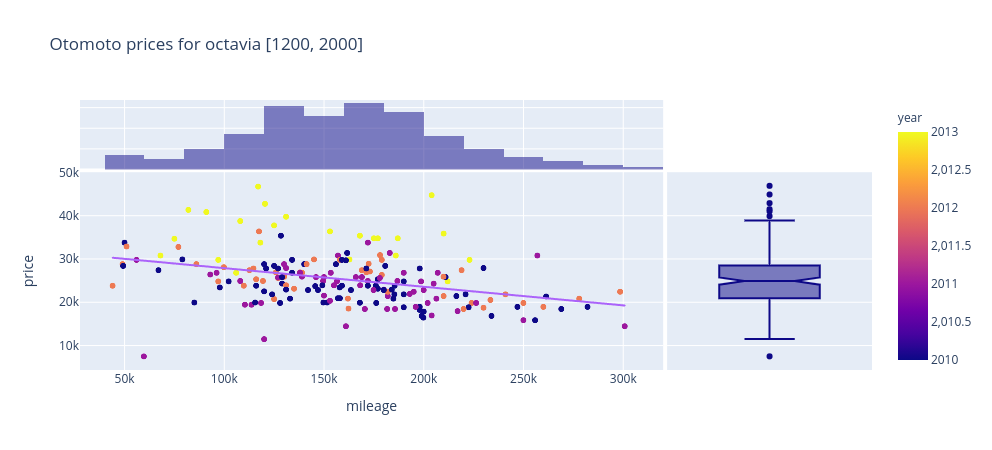

In [25]:
def plot_scatter(df, model, years, fuel_type, engine):
    """Plot scatter plot for a given search criteria"""
    data = df.query(
        "model == @model & "
        "year < @years[1] & "
        "year >= @years[0] & "
        "fuel_type == @fuel_type & "
        "engine < @engine[1] & "
        "engine >= @engine[0]"
    )
    return px.scatter(
        data, x="mileage", y="price", color="year",
        render_mode="webgl", 
        title=f"Otomoto prices for {model} {engine}",
        marginal_y="box", marginal_x="histogram",
        trendline="ols"
    )

plot_scatter(df, "octavia", [2010, 2014], "Benzyna", [1200, 2000]).show()

In [ ]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

app = JupyterDash("otomoto")
app.layout = html.Div([
    html.H1("Otomoto explorer"),
    dcc.Graph(id='graph'),
    html.Label([
        "model",
        dcc.Dropdown(
            id='model-dropdown', clearable=False,
            value='civic', options=[
                {'label': c, 'value': c}
                for c in MODELS
            ])
    ]),
    html.Label([
        "year",
        dcc.RangeSlider(
            id="year-selector",
            min=1998,
            max=2021,
            value=[2014, 2018],
            marks={ix: str(ix) for ix in range(1998, 2022)}
        )
    ]),
    html.Label([
        "fuel_type", 
        dcc.Dropdown(
            id="fuel_type-selector",
            options=[{'label': f, 'value': f} for f in df.fuel_type.unique()],
            value='Benzyna'
        )  
    ]),
    html.Label([
        "engine",
        dcc.RangeSlider(
            id="engine-selector",
            min=df.engine.min(),
            max=df.engine.max(),
            value=[df.engine.min(), df.engine.max()],
            step=100,
        )
    ])
    
])


# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [
        Input("model-dropdown", "value"),
        Input("year-selector", "value"),
        Input("fuel_type-selector", "value"),
        Input("engine-selector", "value")
    ],
)
def update_figure(model, years, fuel_type, engine):
    data = df.query(
        "model == @model & "
        "year < @years[1] & "
        "year >= @years[0] & "
        "fuel_type == @fuel_type & "
        "engine < @engine[1] & "
        "engine >= @engine[0]")
    return px.scatter(
        data, x="mileage", y="price", color="year",
        render_mode="webgl", title=f"Otomoto prices for {model} {engine}",
        marginal_y="box", marginal_x="histogram",
        trendline="ols"
    )



app.run_server(mode='inline')

In [26]:
def plot_price_decline(df, num_years=3):
    EXAMPLE_THRESHOLD = 5
    YEAR_THRESHOLD = 3
    group_criteria = ['model', 'fuel_type', "engine", 'year']
    gdf = df.groupby(by=group_criteria)
    gdf = gdf.filter(lambda x: x.otomoto_id.nunique() > EXAMPLE_THRESHOLD)
    
    gdf = gdf.groupby(by=group_criteria).price.median().to_frame()
    gdf["count"] = df.groupby(by=group_criteria).otomoto_id.nunique()
    gdf[f"price_{num_years}"] = gdf.groupby(group_criteria[:-1]).price.shift(num_years)
    gdf[f"price_diff_{num_years}"] = gdf.price - gdf[f"price_{num_years}"]
    gdf[f"price_ratio_{num_years}"] = (gdf.price - gdf[f"price_{num_years}"])/gdf.price
    gdf = gdf[
        gdf[f"price_ratio_{num_years}"].notnull()
    ].sort_values(
        f'price_diff_{num_years}'
    )[["count", "price", f"price_{num_years}", f"price_diff_{num_years}", f"price_ratio_{num_years}"]]
    return gdf


# For every (fuel_type, engine, year) combination for a given model, calculate the price decline
# for a given time horizon
plot_price_decline(df, num_years=4).xs("tiguan", level=0)

count     price  price_4  price_diff_4  price_ratio_4
fuel_type engine year                                                       
Benzyna   1390.0 2013  18     46449.5   31900.0  14549.5       0.313233     
Diesel    1968.0 2012  56     45900.0   30900.0  15000.0       0.326797     
Benzyna   1390.0 2012  25     44500.0   29350.0  15150.0       0.340449     
          1984.0 2012  6      50350.0   32800.0  17550.0       0.348560     
Diesel    1968.0 2013  36     52249.5   33900.0  18349.5       0.351190     
                 2015  32     60900.0   42500.0  18400.0       0.302135     
Benzyna   1390.0 2014  10     53349.5   34900.0  18449.5       0.345823     
Diesel    1968.0 2014  53     55555.0   36950.0  18605.0       0.334893     
          2000.0 2014  6      54900.0   35900.0  19000.0       0.346084     
                 2013  10     52400.0   31250.0  21150.0       0.403626     
          1968.0 2016  46     83900.0   45900.0  38000.0       0.452920     
                 2017  39     91899.0   52249.5  39649.5       0.431446     
Benzyna   1984.0 2018  6      85000.0   39000.0  46000.0       0.541176     
                 2017  10     89700.5   34300.0  55400.5       0.617616     
Diesel    1968.0 2018  15     116900.0  55555.0  61345.0       0.524765     
Benzyna   1984.0 2016  7      99000.0   33900.0  65100.0       0.657576     
Diesel    1968.0 2020  7      152500.0  83900.0  68600.0       0.449836     
Benzyna   1984.0 2019  6      119350.0  50350.0  69000.0       0.578132     
Diesel    1968.0 2019  14     140700.0  60900.0  79800.0       0.567164

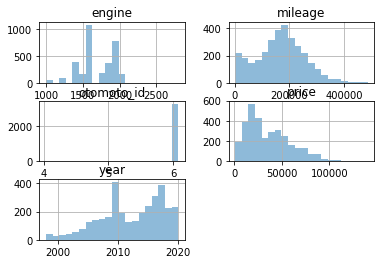

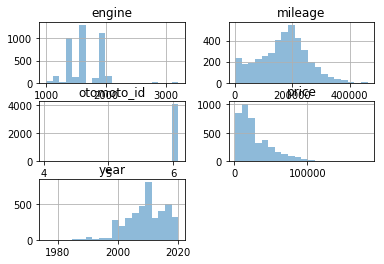

In [28]:
def plot_mileage_hist(query, plot_params):
    mileage = df.query(query)
    mileage.hist(bins=20, **plot_params)

for i_model in ["octavia", "golf"]:
    plot_mileage_hist(f"model == '{i_model}'", {'alpha': 0.5})